# exp015_train
[Notion](https://www.notion.so/exp011-4a459065840b4614b0381125851ca87e?pvs=4)  
腸管の損傷と血管外漏出の分類モデルの作成(2D-CNN)

Copy From: exp011_train <- exp010_train

In [1]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from typing import Tuple

import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.cuda.amp as amp
from sklearn.model_selection import GroupKFold
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')

from src.classification.dataset import TrainDatasetBowelExtra as TrainDataset
from src.classification.dataset import save_df, load_df
from src.image_processing import windowing
from src.logger import get_logger
from src.classification.model import lock_model_encoder_weight
from src.classification.trainer import fit_model

# Config

In [2]:
class CFG:
    exp_name = 'exp_015'
    # model config
    # timm backbone
    backbone = 'efficientnet_b4'
    # n_ch: z軸方向のスライス数
    n_ch = 1 # support only 1
    expand_ch_dim = False
    # n_class: bowel_injury, extravasation
    n_class = 2
    label_smoothing = None #Optional(float)
    # hyper params
    init_lr = 1e-4
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (512, 512)
    batch_size = 64
    amp = True
    eps = 1e-6
    n_epoch = 20
    iteration_per_epoch = 200
    pretrain = False
    freeze_epochs = 0
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset001"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 0
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# create output dir
os.makedirs(os.path.join(CFG.model_save_dir, CFG.exp_name), exist_ok=True)

# seed setting
def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

# logger setting
logger = get_logger(CFG)

# load dataframe
df_train = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train.csv')
df_train_image_level = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')
df_train_series_meta = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

# Dataset  
foldはexp009の固形臓器の分類を読み込み使用する.

In [4]:
class SolidOrganCFG:
    exp_name = 'exp_009'
    model_save_dir = "outputs"
df_solid_organ = load_df(SolidOrganCFG)

In [5]:
def get_weight(df: pd.DataFrame, target: str, positive_rate: float)-> float:
    """サンプラーのための重みを算出する.
    Args:
        df (pd.DataFrame): 学習用df.
        target (str): 重みを算出するターゲットクラス.
        positive_rate (float): ターゲットクラスの正例率.
        """
    default_positive_rate = df[target].sum()/len(df)*100
    mul = positive_rate/default_positive_rate
    return mul

def get_training_dataframe():
    """データセットのDataFrameを作成する.
    データセットによって内容を書き換える必要あり.
    """
    # df_train_series_metaをベースに、学習用データフレームを構築.
    # 損傷がある場合、df_train_image_levelにデータがある.
    path_dict = defaultdict(list)
    for i in tqdm(range(len(df_train_series_meta))):
        sr = df_train_series_meta.iloc[i]
        pid, sid = int(sr["patient_id"]), int(sr["series_id"])
        fold = df_solid_organ[df_solid_organ["patient_id"] == pid].iloc[0]["fold"]
        patient_label = df_train[df_train["patient_id"] == pid].iloc[0]
        bowel_healthy = patient_label["bowel_healthy"]
        extravasation_healthy = patient_label["extravasation_healthy"]
        if bowel_healthy and extravasation_healthy:
            series_label = None
        else:
            series_label = df_train_image_level[(df_train_image_level["patient_id"] == pid) & (df_train_image_level["series_id"] == sid)]
        path_list = os.listdir(os.path.join(CFG.image_dir,"train_images" ,str(pid), str(sid)))
        path_list = [[int(path.replace(".npy","")), path] for path in path_list]
        path_list.sort()
        for image_id, path in path_list:
            path_dict["patient_id"].append(pid)
            path_dict["series_id"].append(sid)
            path_dict["image_id"].append(image_id)
            if series_label is None:
                labels = []
            else:
                image_label = series_label[series_label["instance_number"] == image_id]
                labels = image_label["injury_name"].values
            if "Bowel" in labels:
                path_dict["bowel"].append(1)
            else:
                path_dict["bowel"].append(0)
            if "Active_Extravasation" in labels:
                path_dict["extravasation"].append(1)
            else:
                path_dict["extravasation"].append(0)
            path_dict["fold"].append(fold)

    # 画像データのDataFrameを作成
    df = pd.DataFrame(path_dict)

    # データ不均衡調整のためweightをかける
    df["weight"] = 1
    positive_rate = 3
    for target in ["bowel","extravasation"]:
        mul = get_weight(df,target,positive_rate)
        for i in range(len(df)):
            if df[target][i]:
                df["weight"][i] = mul

    return df

In [6]:
df = get_training_dataframe()
save_df(df, CFG)
df.head()

100%|██████████| 4711/4711 [00:16<00:00, 291.39it/s]


,patient_id,series_id,image_id,bowel,extravasation,fold,weight
0,10004,21057,171,0,0,1,1.0
1,10004,21057,172,0,0,1,1.0
2,10004,21057,173,0,0,1,1.0
3,10004,21057,174,0,0,1,1.0
4,10004,21057,175,0,0,1,1.0


In [7]:
def apply_preprocess(image: np.ndarray)-> np.ndarray:
    """データ前処理. カスタマイズして使用.
    Args:
        image (numpy.ndarray): HU値のCT画像.
    Returns:
        image (numpy.ndarray): windowing及び0~1に正規化.
    """
    # 0~1に正規化
    image = windowing(image, wl=0, ww=400, mode="float32")
    return image

def get_aug():
    """データ拡張. カスタマイズして使用.
    Note:
        画像のResizeはDataset側で行うので、この関数に入れる必要はない.
    """
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5
            ),
            A.OneOf(
                [
                    A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),
                ],
                p=0.25,
            ),
            A.CoarseDropout(
                max_holes=8,
                max_height=CFG.image_size[0] // 20,
                max_width=CFG.image_size[1] // 20,
                min_holes=5,
                fill_value=0,
                mask_fill_value=0,
                p=0.5,
            ),
        ],
        p=1.0,
    )

In [8]:
df_valid = df[df["fold"] == 0].reset_index(drop=True)
ds = TrainDataset(CFG, df_valid, preprocess=apply_preprocess, tfms=None)# get_aug())

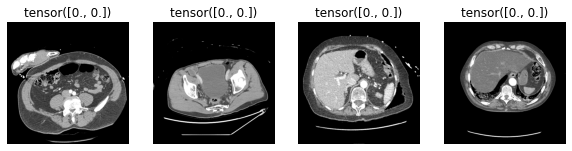

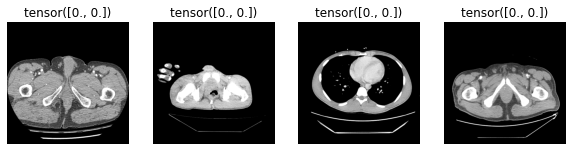

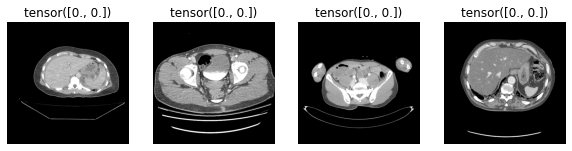

In [9]:
for i in range(3):
    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    for j in range(4):
        img, label = ds[random.randint(0, len(ds)-1)]
        ax[j].imshow(img.numpy()[img.shape[0]//2], cmap='gray')
        ax[j].set_title(label)

    for j in range(4):
        ax[j].grid(False)
        ax[j].axis(False)

In [10]:
result_dict = {}

for fold in range(CFG.train_folds):
    logger.info(f"Fitting on Fold {fold+1}")
    # Dataset
    if CFG.include_evaluation: # evaluation用のデータを最後のfoldに含める場合
        df_train = df[(df["fold"] != fold) & (df["fold"] != CFG.n_fold-1)].reset_index(drop=True)
        df_valid = df[df["fold"] == fold].reset_index(drop=True)
    else:
        df_train = df[df["fold"] != fold].reset_index(drop=True)
        df_valid = df[df["fold"] == fold].reset_index(drop=True)
    train_data = TrainDataset(
        CFG, df_train, preprocess=apply_preprocess, tfms=get_aug()
    )
    valid_data = TrainDataset(CFG, df_valid, preprocess=apply_preprocess, tfms=None)

    # Sampler
    # 各クラスを均等に学習することで、効率的に学習する.
    train_sampler = torch.utils.data.sampler.WeightedRandomSampler(
        torch.DoubleTensor(df_train["weight"].values), 
        CFG.iteration_per_epoch*CFG.batch_size)
    valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(
        torch.DoubleTensor(df_valid["weight"].values), 
        CFG.iteration_per_epoch*CFG.batch_size)

    # Data Loader
    train_iterator = DataLoader(
        train_data,
        sampler=train_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )
    valid_iterator = DataLoader(
        valid_data,
        sampler=valid_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    # noaug_iterator
    train_noaug_data = TrainDataset(
        CFG, df_train, preprocess=apply_preprocess, tfms=None
    )
    train_noaug_iterator = DataLoader(
        train_noaug_data,
        sampler=train_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    if CFG.amp:
        model = timm.create_model(
            CFG.backbone, 
            pretrained=CFG.pretrain, 
            num_classes=CFG.n_class, 
            in_chans=CFG.n_ch
        ).to(CFG.device)
        scaler = amp.GradScaler()
    else:
        model = timm.create_model(
            CFG.backbone, 
            pretrained=CFG.pretrain, 
            num_classes=CFG.n_class, 
            in_chans=CFG.n_ch
        ).to(CFG.device)
        scaler = None
    if CFG.num_gpus > 1:
        model = nn.DataParallel(model)

    model_name = f"{CFG.exp_name}_f{fold}"

    if CFG.freeze_epochs:
        logger.info("+-+-+-+-+-+-+-+-+")
        logger.info("pretrain mode")
        logger.info("+-+-+-+-+-+-+-+-+")

        loss_criterion = nn.BCEWithLogitsLoss()
        opt = AdamW(model.parameters(), lr=CFG.init_lr, eps=CFG.eps)
        scheduler = None

        model = lock_model_encoder_weight(model, mode="lock")

        _ = fit_model(
            CFG,
            model,
            model_name,
            train_iterator,
            train_noaug_iterator,
            valid_iterator,
            opt,
            loss_criterion,
            True,
            scaler,
            logger,
            scheduler,
            None
        )

    logger.info("@*@*@*@*@*@*@*@*@")
    logger.info("fulltrain mode")
    logger.info("@*@*@*@*@*@*@*@*@")

    loss_criterion = nn.BCEWithLogitsLoss()
    opt = AdamW(model.parameters(), lr=CFG.init_lr, weight_decay=CFG.weight_decay, eps=CFG.eps)
    scheduler = CosineAnnealingLR(opt, CFG.n_epoch, eta_min=CFG.min_lr)

    model = lock_model_encoder_weight(model, mode="unlock")
    
    tr_loss, val_loss, val_metrics = fit_model(
        CFG,
        model,
        model_name,
        train_iterator,
        train_noaug_iterator,
        valid_iterator,
        opt,
        loss_criterion,
        False,
        scaler,
        logger,
        scheduler,
        None
    )

    result = {
        "tr_loss": tr_loss, 
        "val_loss": val_loss, 
        "val_metrics": val_metrics,
    }
    result_dict[model_name] = result

2023-08-19 11:52:09,133 INFO: Fitting on Fold 1
2023-08-19 11:52:11,042 INFO: @*@*@*@*@*@*@*@*@
2023-08-19 11:52:11,043 INFO: fulltrain mode
2023-08-19 11:52:11,043 INFO: @*@*@*@*@*@*@*@*@
Validation loss: 0.24290: 100%|██████████| 200/200 [00:35<00:00,  5.62it/s]
2023-08-19 12:12:09,144 INFO: Epoch: 01 | Epoch Time: 19m 58s
2023-08-19 12:12:09,145 INFO: lr:0.0001000
2023-08-19 12:12:09,145 INFO: Train Loss: 0.235
2023-08-19 12:12:09,145 INFO: Val. Loss: 0.153 | Val. Logloss Score : 0.052,
Validation loss: 0.16673: 100%|██████████| 200/200 [00:42<00:00,  4.66it/s]
2023-08-19 12:32:34,018 INFO: Epoch: 02 | Epoch Time: 20m 25s
2023-08-19 12:32:34,019 INFO: lr:0.0000994
2023-08-19 12:32:34,020 INFO: Train Loss: 0.146
2023-08-19 12:32:34,020 INFO: Val. Loss: 0.160 | Val. Logloss Score : 0.051,
Validation loss: 0.13978: 100%|██████████| 200/200 [00:43<00:00,  4.55it/s]
2023-08-19 12:53:00,597 INFO: Epoch: 03 | Epoch Time: 20m 27s
2023-08-19 12:53:00,598 INFO: lr:0.0000976
2023-08-19 12:53:0

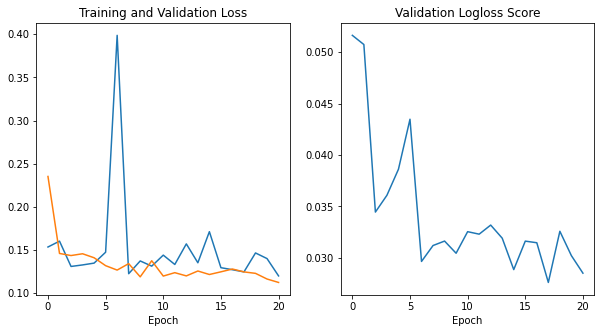

In [11]:
for fold in range(CFG.train_folds):
    model_name = f"{CFG.exp_name}_f{fold}"
    val_loss = result_dict[model_name]["val_loss"]
    val_dice = result_dict[model_name]["val_metrics"]
    tr_loss = result_dict[model_name]["tr_loss"]

    fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].plot(val_loss)
    ax[0].plot(tr_loss)
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(val_dice)
    ax[1].set_title('Validation Logloss Score')
    ax[1].set_xlabel('Epoch')